In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import os
import pickle
import pandas as pd

In [2]:
fontsize = 18
rcparams = {}
rcparams['figure.figsize'] = (10, 6)
rcparams['axes.labelsize'] = fontsize
rcparams['legend.fontsize'] = fontsize-4
rcparams['axes.titlesize'] = fontsize
rcparams['axes.linewidth'] = 2
rcparams['axes.grid'] = True
for axis in ['x', 'y']:
    rcparams['%stick.labelsize'%axis] = fontsize-2
    rcparams['%stick.direction'%axis] = 'in'
    rcparams['%stick.major.size'%axis] = 5.5
    rcparams['%stick.minor.size'%axis] =  3.5
    rcparams['%stick.major.width'%axis] = 2
    rcparams['%stick.minor.width'%axis] = 1.5
rcparams['xtick.top'] = True
rcparams['ytick.right'] = True
for key in rcparams: mpl.rcParams[key] = rcparams[key]

Read in summary data for one halo to check the format etc.

In [3]:
foldername = '../data/tng_2d_summary/'

In [4]:
for f in [f for f in os.listdir(foldername)][0:1]:
    haloId = f.split('_')[1]
    print(haloId)
    data = np.load('%s/%s' % (foldername, f))

267700


In [5]:
data.keys()

dict_keys(['catsh_id', 'aper_x0', 'aper_y0', 'aper_ba', 'aper_pa', 'aper_rkpc', 'aper_logms', 'rpix_shape', 'mu_shape', 'mu_err_shape', 'e_shape', 'e_err_shape', 'pa_shape', 'pa_err_shape', 'maper_shape', 'rpix_prof', 'mu_prof', 'mu_err_prof', 'maper_prof', 'output_shape', 'output_prof'])

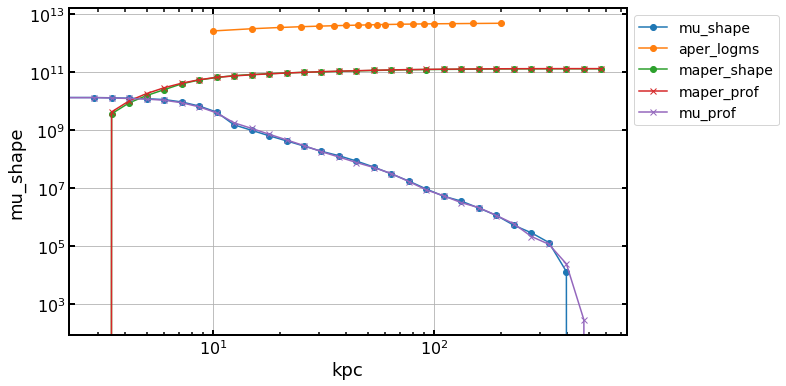

In [6]:
plt.plot(data['rpix_shape'] * 5.333, data['mu_shape'], 'o-', label='mu_shape')
plt.plot(data['aper_rkpc'], 10 ** data['aper_logms'], 'o-', label='aper_logms')
plt.plot(data['rpix_shape'] * 5.333, data['maper_shape'], 'o-', label='maper_shape')
plt.plot(data['rpix_prof'] * 5.333, data['maper_prof'], 'x-', label='maper_prof')
plt.plot(data['rpix_prof'] * 5.333, data['mu_prof'], 'x-', label='mu_prof')

plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('kpc')
plt.ylabel('mu_shape')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

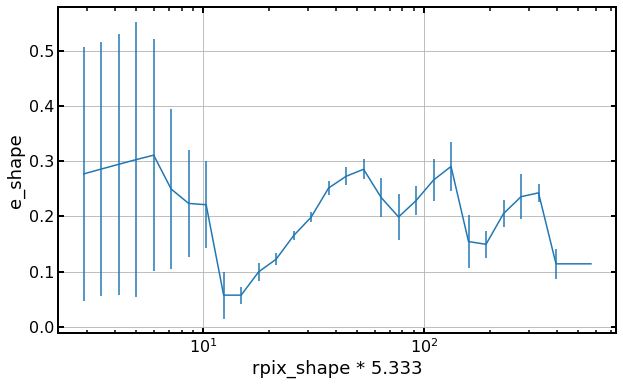

In [7]:
plt.errorbar(data['rpix_shape'] * 5.333, data['e_shape'], yerr=data['e_err_shape'])
plt.xlabel('rpix_shape * 5.333')
plt.ylabel('e_shape')
plt.gca().set_xscale('log')

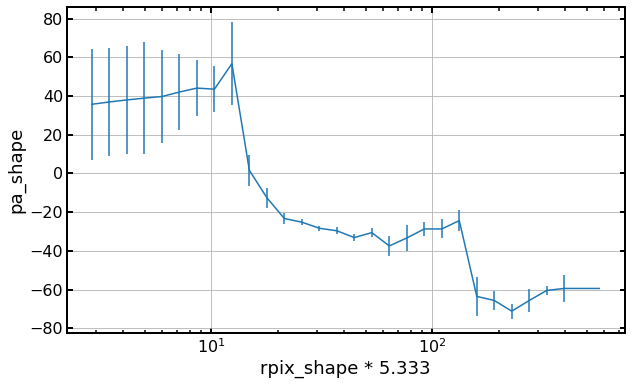

In [8]:
plt.errorbar(data['rpix_shape'] * 5.333, data['pa_shape'], yerr=data['pa_err_shape'])
plt.xlabel('rpix_shape * 5.333')
plt.ylabel('pa_shape')
plt.gca().set_xscale('log')

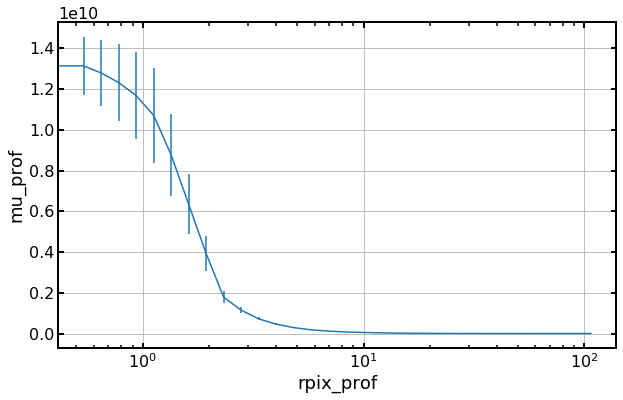

In [9]:
plt.errorbar(data['rpix_prof'], data['mu_prof'], yerr=data['mu_err_prof'])
plt.xlabel('rpix_prof')
plt.ylabel('mu_prof')
plt.gca().set_xscale('log')

Now read in the 3D shapes data. Also store the haloIDs to ensure that we use the corresponding summary data.

In [10]:
data_dir = '../outputs/tng-100/'

shape_data = {}
haloIDs = []
# loop over the local foders; each folder is for a specific halo
for i, folder in enumerate([f for f in os.listdir(data_dir) if f.startswith('TNG')]):
    haloId = int(folder.split('halo')[-1].split('_')[0])
    
    if haloId != 106030:
        haloIDs.append(haloId)
        #print('Considering halo %s' % haloId)
        # ---------------------------------------------------------------------
        # now read in the data produced from my version
        file = [ f for f in os.listdir('%s/%s' % (data_dir, folder)) if f.startswith('shape_')][0]

        #print('Reading %s' % (file))
        with open('%s/%s/%s' % (data_dir, folder, file), 'rb') as f:
            data_now = pickle.load(f)

        if i == 0:
            shape_data['b/a_20'] = [ data_now['b/a'][0] ] 
            shape_data['b/a_100'] = [ data_now['b/a'][1] ]
            shape_data['c/a_20'] = [ data_now['c/a'][0] ]
            shape_data['c/a_100'] = [ data_now['c/a'][1] ]
        else:
            shape_data['b/a_20'] += [ data_now['b/a'][0] ] 
            shape_data['b/a_100'] += [ data_now['b/a'][1] ]
            shape_data['c/a_20'] += [ data_now['c/a'][0] ]
            shape_data['c/a_100'] += [ data_now['c/a'][1] ]
            
shape_data = pd.DataFrame(shape_data )
shape_data.shape

(234, 4)

In [11]:
def get_features(data_for_halo):
    
    features = {}
    for key in ['aper_x0', 'aper_y0', 'aper_ba', 'aper_pa']:
        features[key] = data_for_halo[key]

    for pair in [[10, 50], [50, 100], [100, 150], [150, 200]]:
        inner, outer = pair
        ind_inner = np.where(data_for_halo['aper_rkpc'] == inner)[0]
        ind_outer = np.where(data_for_halo['aper_rkpc'] == outer)[0]
        M_in = 10 ** data_for_halo['aper_logms'][ind_inner][0]
        M_out = 10 ** data_for_halo['aper_logms'][ind_outer][0]
        features['delM_%s_%s' % (inner, outer)] = (M_out - M_in) / M_out
    

    for pair in [[1, 8], [8, 12], [12, 16], [16, 20],
                 [20, 24], [24, 28], [28, 30]]:
        ind_inner, ind_outer = pair
        inner, outer = data_for_halo['rpix_shape'][ind_inner] * 5.333, data_for_halo['rpix_shape'][ind_outer] * 5.333

        e_in =  data_for_halo['e_shape'][ind_inner]
        e_out = data_for_halo['e_shape'][ind_outer]

        features['dele_%.f_%.f' % (inner, outer)] = (e_out - e_in) / e_out

        pa_in =  data_for_halo['pa_shape'][ind_inner]
        pa_out = data_for_halo['pa_shape'][ind_outer]
        del_pa = pa_out - pa_in
        if del_pa > 45: del_pa -= 45
        if del_pa < -45: del_pa += 45

        features['delpa_%.f_%.f' % (inner, outer)] = del_pa / pa_out

    
    return features

Assemble the features based on the summary data.

In [12]:
for i, haloId in enumerate(haloIDs):
    f = [f for f in os.listdir(foldername) if f.__contains__('_%s_'%haloId)]
    if len(f) != 1:
        print(f, haloId)
        break
    else:
        f = f[0]
    
    data = np.load('%s/%s' % (foldername, f))
    out = get_features(data_for_halo=data)
    if i == 0:
        keys = out.keys()
        feats = list(out.values())
    else:
        feats = np.vstack([feats, list(out.values())])
#
feats = pd.DataFrame(feats, columns=keys)
feats.shape

(234, 22)

Try pairplots

In [13]:
import seaborn as sns

CPU times: user 953 ms, sys: 72.1 ms, total: 1.03 s
Wall time: 603 ms


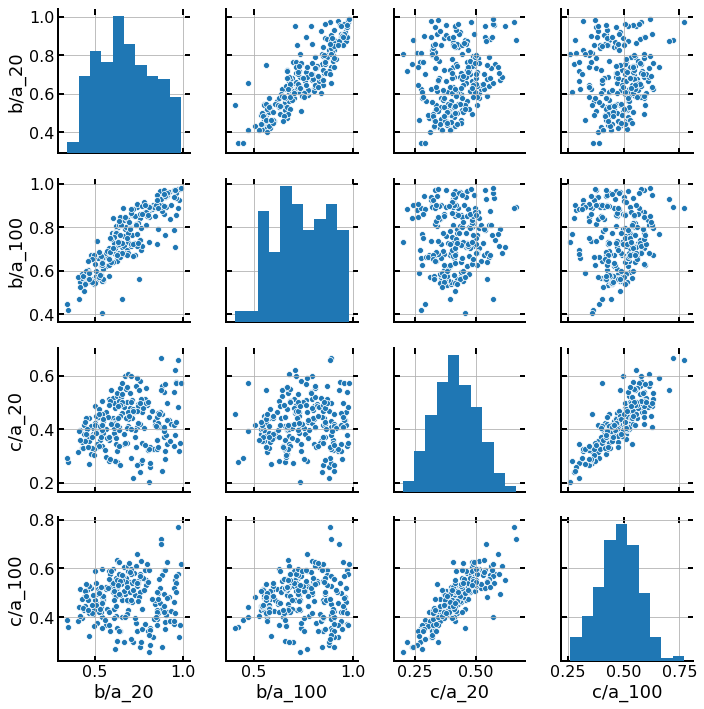

In [14]:
%%time
sns.pairplot(shape_data)

CPU times: user 34.7 s, sys: 2.38 s, total: 37.1 s
Wall time: 22 s


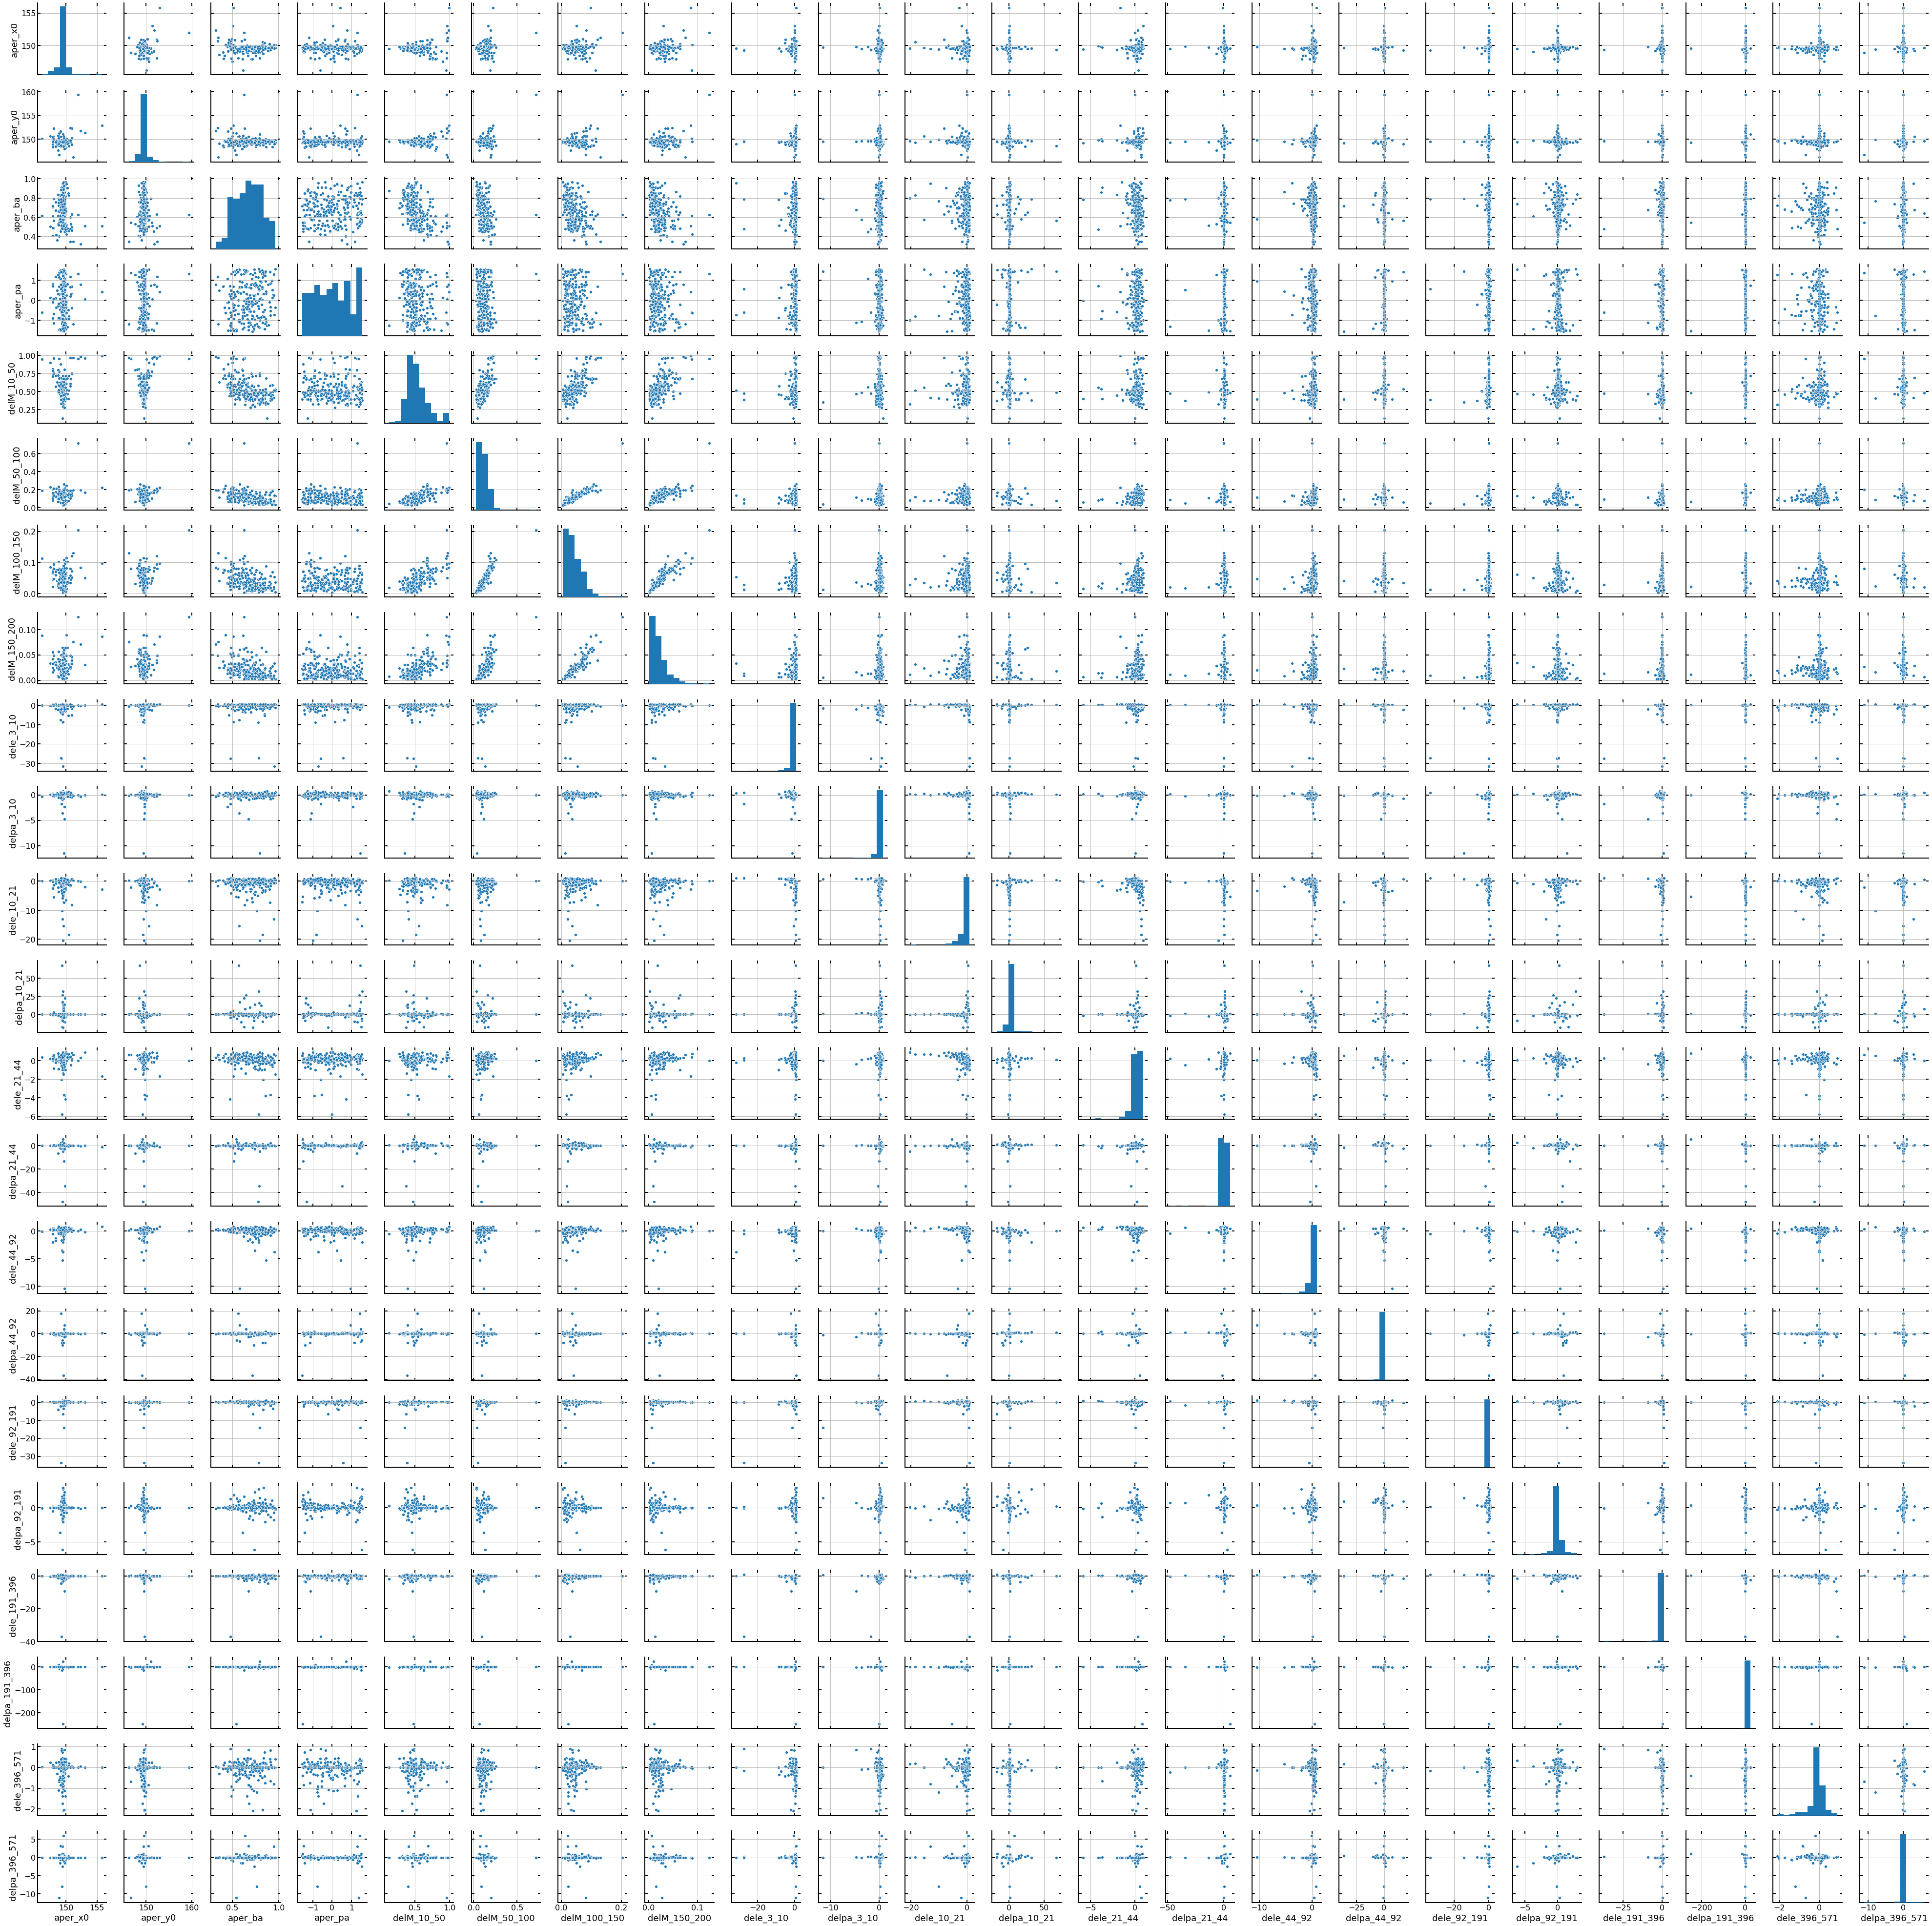

In [15]:
%%time
sns.pairplot(feats)

Try RF Regression

In [16]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ShuffleSplit, validation_curve, train_test_split
from sklearn.ensemble import RandomForestRegressor

In [17]:
def get_mse(x_test_arr, x_pred_arr):
    target_dim = np.size(x_test_arr, axis= 1)

    if (target_dim > 1):
        mse = np.zeros(target_dim)
        for i in range(target_dim):
            mse[i] = mean_squared_error(x_test_arr[:, i], x_pred_arr[:, i])
    else:
        mse = [mean_squared_error(x_test_arr, x_pred_arr)]

    return mse

def plot_validation_curve(param_name, parameter_values, training_scores, validation_scores):
    training_scores_mean = np.mean(training_scores, axis=1)
    training_scores_std = np.std(training_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.clf()
    plt.fill_between(parameter_values, training_scores_mean - training_scores_std,
                     training_scores_mean + training_scores_std, alpha=0.1, color="r")
    plt.fill_between(parameter_values, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(parameter_values, training_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(parameter_values, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(validation_scores_mean.min() - .1, training_scores_mean.max() + .1)
    plt.xlabel(param_name)
    plt.legend(loc="best")
    plt.show()
    

def rf_reg(x_train, y_train, x_test, y_test, validate=True):
    RF = RandomForestRegressor(n_estimators=20, verbose=0)
    # fit the model
    RF.fit(x_train, y_train)
    # predict on the test data
    y_pred = RF.predict(x_test)
    # see how well predictor is working.
    mse = get_mse(y_test, y_pred)
    r2 = RF.score(x_test, y_test)   # best possible score is 1.0
    print('\nRF regression:\nMSE:%s\nR2 score = %s'%(mse, r2))
    print('Feature importance:\n ', RF.feature_importances_)

    if validate:
        # vary the number of neighbors used:
        param_name = "n_estimators"
        param_range = np.array([1, 2, 4, 16, 128])
        
        # need a cv iterator:
        shuffle_split = ShuffleSplit(train_size=0.5, n_splits=10,
                                     test_size=0.25, random_state=492)
        
        # Compute cv scores for a range of the no. of estimators:
        training_scores_RF, validation_scores_RF = validation_curve(RF, x_train, y_train,
                                                                    param_name=param_name,
                                                                    param_range=param_range, 
                                                                    cv=shuffle_split, scoring='r2')
        plot_validation_curve(param_name, param_range, training_scores_RF, validation_scores_RF)
        
    return [y_pred, mse, RF]


In [18]:
x_train, x_test, y_train, y_test = train_test_split(feats.values, shape_data.values,
                                                    test_size=0.33, random_state=42)

/Users/humnaawan/anaconda3/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)



RF regression:
MSE:[0.02274917 0.01348459 0.00599173 0.00705082]
R2 score = 0.09201457024224594
Feature importance:
  [0.04316219 0.05083415 0.04113849 0.06461252 0.07186845 0.12286164
 0.08739713 0.07926841 0.02098314 0.03314594 0.01887272 0.0380591
 0.03687253 0.03410085 0.04259127 0.04013996 0.02362322 0.02207375
 0.05998206 0.02018715 0.03704785 0.01117748]


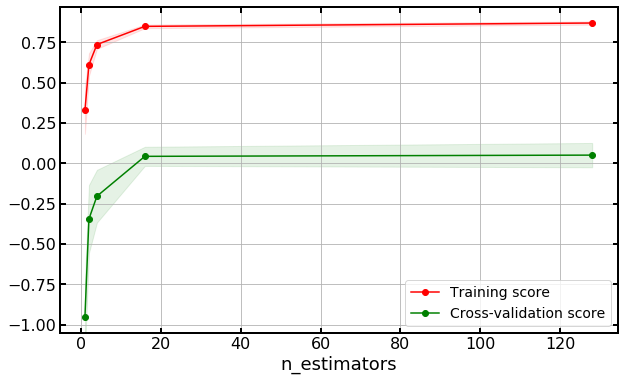

In [19]:
y_RF_pred, mse_RF_test, RF = rf_reg(x_train=x_train, y_train=y_train,
                                    x_test=x_test, y_test=y_test, validate=True)

In [20]:
# assemble the DFs
shape_data_test = pd.DataFrame(y_test,
                               columns=['b/a_20', 'b/a_100', 'c/a_20', 'c/a_100'])
pred_shape_data = pd.DataFrame(y_RF_pred, columns=['b/a_20_pred', 'b/a_100_pred', 'c/a_20_pred', 'c/a_100_pred'])

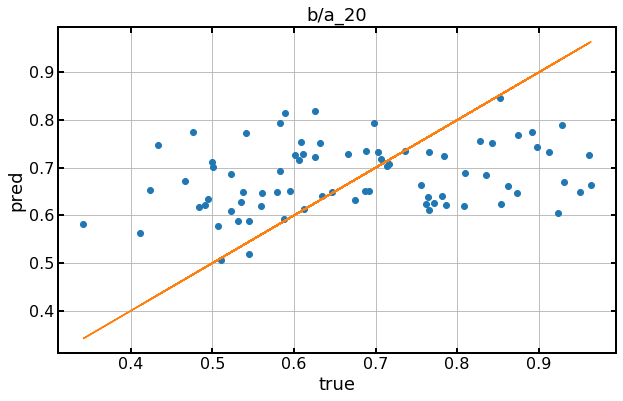

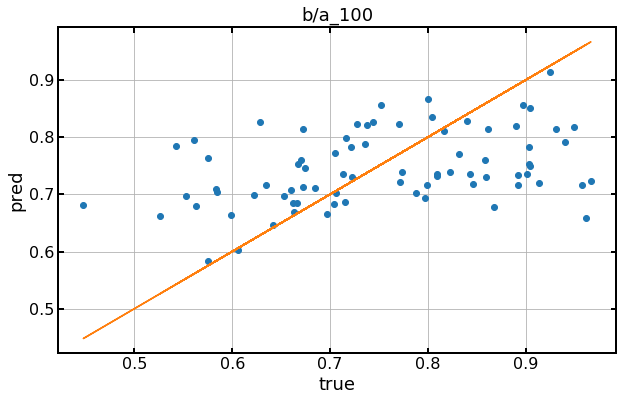

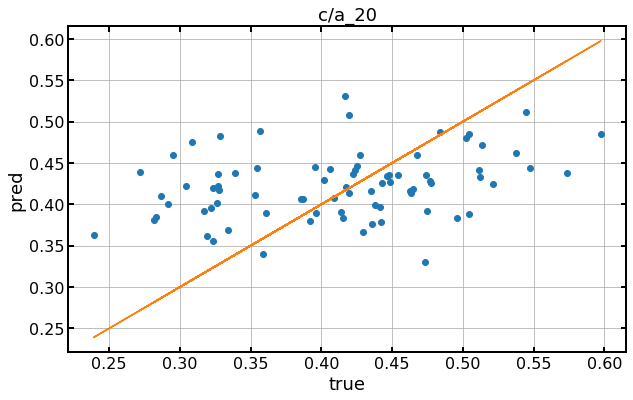

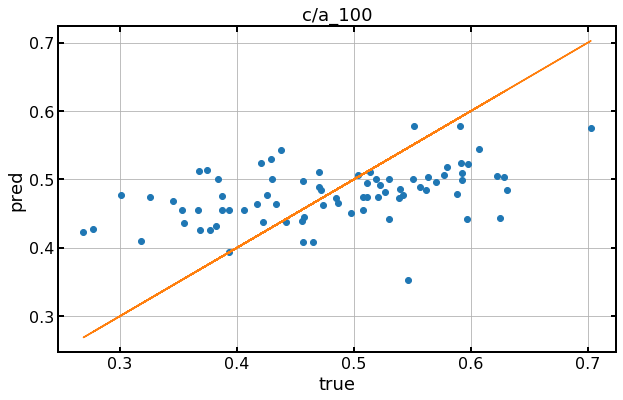

In [21]:
for key in shape_data_test:
    plt.plot(shape_data_test[key].values, pred_shape_data['%s_pred' % key].values, 'o')
    plt.plot(shape_data_test[key].values, shape_data_test[key].values, '-')
    plt.xlabel('true')
    plt.ylabel('pred')
    plt.title(key)
    plt.show()